### Building a ChemProp model with RDKit descriptors

This notebook shows how to build a ChemProp model using RDKit descriptors as additional features.  The notebook borrows heavily from the ChemProp examples. 
1. Read the input data
2. Divide the dataset into training, validation, and test sets
3. Calculate RDKit descriptors
4. Create the datasets
5. Create dataloaders
6. Create the model
7. Train the model
8. Predict the values for the test set
9. Evaluate the model

In [1]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import useful_rdkit_utils as uru
from chemprop import data, featurizers, nn, models
from lightning import pytorch as pl
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

### 1. Read the input data
Read the input data. For this exercise, we'll use one of the datasets from [this paper by Fang et al](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00160). 

In [2]:
df = pd.read_csv("/Users/pwalters/software/benchmark/data/biogen_logS.csv")
y_col = "logS"

### 2. Divide the dataset into training, validation, and test sets
Divide the dataset into training, validation, and test sets.  ChemProp has functions for dataset splitting, but I thought it might be useful to show how to do it with scikit-learn.

In [3]:
train_frac, val_frac, test_frac = 0.8, 0.1, 0.1
train, test = train_test_split(df, test_size=test_frac)
train, val = train_test_split(train, test_size=len(test))

Examine the sizes of the training, validation, and test sets.

In [4]:
len(train), len(val), len(test)

(1737, 218, 218)

### 3. Calculate RDKit descriptors
A small function to calculate RDKit descriptors using [useful_rdkit_utils](https://useful-rdkit-utils.readthedocs.io/en/latest/).

In [5]:
def calc_descriptors(smi_list):
    generator = uru.RDKitDescriptors()
    return generator.pandas_smiles(smi_list).values.tolist()

Calculate the RDKit descriptors for the training, validation, and test sets.

In [6]:
train['feat'] = calc_descriptors(train.SMILES.values)
val['feat'] = calc_descriptors(val.SMILES.values)
test['feat'] = calc_descriptors(test.SMILES.values)

  0%|          | 0/1737 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

### 4. Create the datasets
Convert the data to MoleculeDatapoints.  We're adding extra molecule features, so we use the **x_d** argument in **data.MoleculeDatapoint.from_smi**.

In [7]:
cols = ["SMILES", y_col, 'feat']
train_pt = [data.MoleculeDatapoint.from_smi(smi, [y], x_d=np.array(X_d)) for smi, y, X_d in train[cols].values]
val_pt = [data.MoleculeDatapoint.from_smi(smi, [y], x_d=np.array(X_d)) for smi, y, X_d in val[cols].values]
test_pt = [data.MoleculeDatapoint.from_smi(smi, [y], x_d=np.array(X_d)) for smi, y, X_d in test[cols].values]

Create a featurizer to generate graph node and edge features for the molecules.

In [8]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

Create a training dataset by featurizing the training set, and normalizing the targets. Create another scaler for the added descriptors. 

In [9]:
train_dset = data.MoleculeDataset(train_pt, featurizer)
scaler = train_dset.normalize_targets()
extra_datapoint_descriptors_scaler = train_dset.normalize_inputs("X_d")

Do the same with the validation dataset.  Use the scalers we created for the training set to scale the validation set descriptors and targets.

In [10]:
val_dset = data.MoleculeDataset(val_pt, featurizer)
val_dset.normalize_targets(scaler)
val_dset.normalize_inputs("X_d", extra_datapoint_descriptors_scaler)

StandardScaler()

Create the test dataset  

In [11]:
test_dset = data.MoleculeDataset(test_pt, featurizer)

### 5. Create dataloaders
Create dataloaders for the training validation and test sets.  

In [12]:
num_workers = 0
train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)

### 6. Create the model
Create the Feed Forward Neural Network (FFNN)

In [13]:
num_extra_features = len(train.feat.values[0])
mp = nn.BondMessagePassing()
ffn_input_dim = mp.output_dim + num_extra_features
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
ffn = nn.RegressionFFN(input_dim=ffn_input_dim, output_transform=output_transform)

Create the Message Passing Neural Network (MPNN)

In [14]:
batch_norm = True
agg = nn.MeanAggregation()
metric_list = [nn.metrics.RMSEMetric()]
X_d_transform = nn.ScaleTransform.from_standard_scaler(extra_datapoint_descriptors_scaler)
mpnn = models.MPNN(mp, agg, ffn, metrics=metric_list, X_d_transform=X_d_transform, batch_norm=batch_norm)

### 7. Train the model
Train the MPNN on the training and validation sets

In [15]:
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=False,
    enable_progress_bar=True,
    accelerator="cpu",
    devices=1,
    max_epochs=20,  # number of epochs to train for
)
trainer.fit(mpnn, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pwalters/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Loading `train_dataloader` to estimate number of stepping batches.
/Users/pwalters/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

  | Name            | Type               | Params
-------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K 
1 | agg             | MeanAggregation    | 0     
2 | bn              | BatchNorm1d        | 600   
3

Sanity Checking: |                                                                                            …

/Users/pwalters/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.


### 8. Predict the values for the test set
Predict the values for the test set. ChemProp returns the results from **predict** as an array of PyTorch tensors, which isn't particularly convenient. We'll fix that below. 

In [16]:
pred_tensor = trainer.predict(mpnn, test_loader)

/Users/pwalters/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

In [17]:
pred = np.array(list(itertools.chain(*pred_tensor))).flatten()

### 9. Evaluate the model
Plot the distribution of the predicted values. I just put this in to make sure the predictions look reasonable.

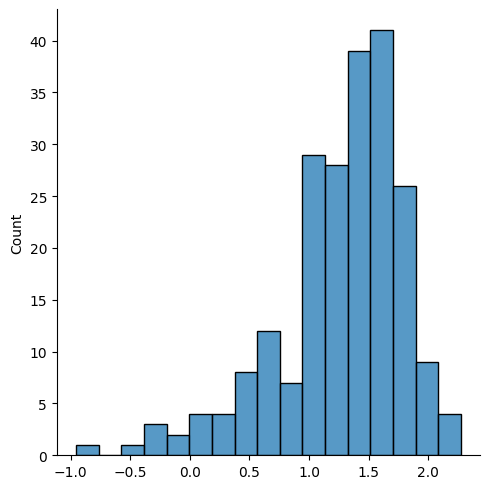

In [18]:
sns.displot(pred)

In [19]:
pred_df = pd.DataFrame({y_col: test[y_col], 'pred': pred})

Plot the experimental vs predicted values.

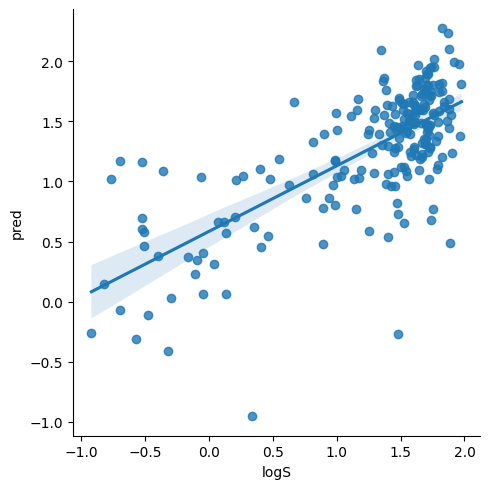

In [20]:
sns.lmplot(x=y_col, y="pred", data=pred_df)

In [21]:
r2_score(pred_df[y_col], pred)

0.5124348553763154

In [22]:
root_mean_squared_error(pred_df[y_col], pred)

0.4879472414309902